In [1]:
"""
a script to download, filter, preprocess, and partition the raw data into training and test splits
"""



'\na script to download, filter, preprocess, and partition the raw data into training and test splits\n'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import json
import os
import scipy

In [3]:
def read_image(ct_path, only_img=False):
    """Reads NIFTI image and returns it as a 3D numpy array"""
    if os.path.exists(ct_path):
        itkimage = sitk.ReadImage(ct_path)
        ct_scan = sitk.GetArrayFromImage(itkimage)
        if only_img:
            return ct_scan
        origin = np.array(list(reversed(itkimage.GetOrigin())))
        spacing = np.array(list(reversed(itkimage.GetSpacing())))
        direction = np.array(list(reversed(itkimage.GetDirection())))
        return ct_scan, origin, spacing
    else:
        print("The file path doesn't exist")
        
ct_path = r"C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\bifurcation_point\3\TRV1P3CTI.nii"
ct_scan, origin, spacing = read_image(ct_path)
print(ct_scan.shape)
print(origin)
print(spacing)

(56, 512, 512)
[0. 0. 0.]
[2.5        0.48828101 0.48828101]


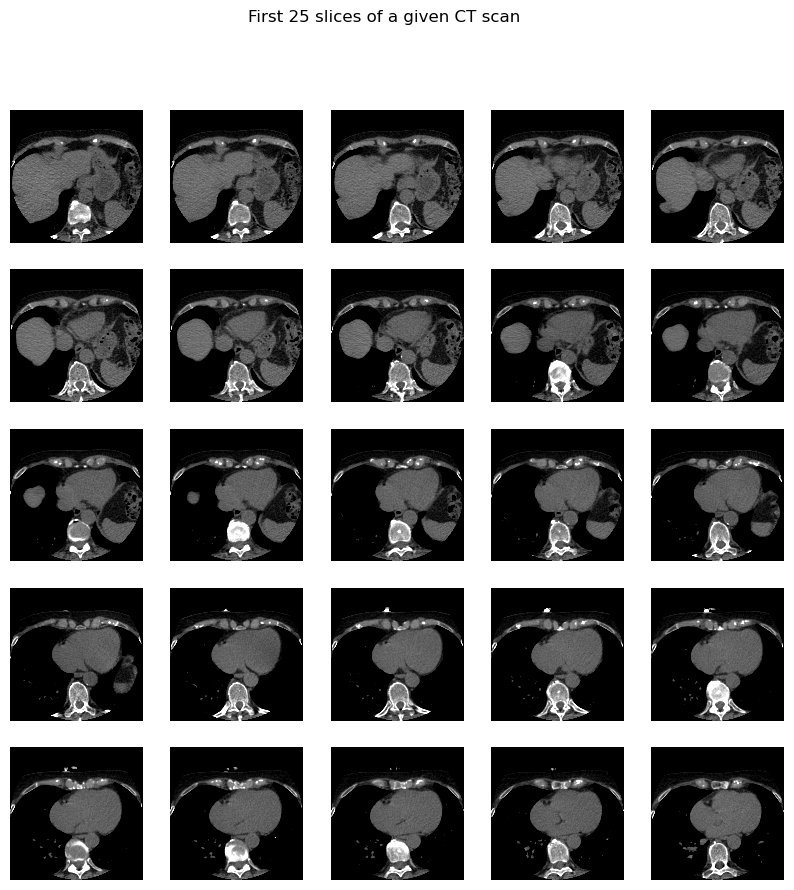

In [4]:
def plot_scan(ct_scan, n=5, window=500, level=100):
    #visualizing the first n*n images of the given patient data
    fig, ax = plt.subplots(n, n, figsize=(10, 10))
    assert n*n < ct_scan.shape[0], "n out of range. Please enter smaller number"
    for i in range(n*n):
        row = i // n
        col = i % n
        vmin = level - window/2
        vmax = level + window/2
        ax[row,col].imshow(ct_scan[i], cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
        ax[row,col].axis('off')
    fig.suptitle(f"First {n*n} slices of a given CT scan")
    plt.show()

plot_scan(ct_scan)

In [6]:
#get 3D bounding box coordinates from json file
def read_from_json(json_path):
    if os.path.exists(json_path):
        with open(label_path) as f:
            label_json = json.load(f)
            x, y, z = label_json['markups'][0]['center']
            length, width, height = label_json['markups'][0]['size']
            orientation = np.array(label_json['markups'][0]['orientation'])
            center, dimension = [x,y,z], [length, width, height]
            return center, dimension
    else:
        print(f"The file '{json_path}' does not exist.")

label_path = r'C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\bifurcation_point\3\bifurcation.json'
center, dimension = read_from_json(label_path)
print(center, dimension)

[146.74349975585938, 135.17697143554688, 99.39756774902344] [7.4595013353900015, 7.346364512383218, 9.047961255810506]


In [39]:
def get_3Dbox_coordinates(json_path, spacing=None, scaling_factor=None):
    center, dimension = read_from_json(json_path)
    if spacing is not None:
        x_center = center[0] / spacing[1]
        y_center = center[1] / spacing[2]
        z_center = center[2] / spacing[0]
        center= [x_center, y_center, z_center]
    if scaling_factor is not None: 
        dimension = dimension * scaling_factor
    return center, dimension
get_3Dbox_coordinates(label_path, spacing=spacing)

([300.5308342435714, 276.8425726770374, 39.759027099609376],
 [7.4595013353900015, 7.346364512383218, 9.047961255810506])

In [ ]:
def normalize_labels(ct_scan, center_coordinates, dimension):
    
    

x_min, y_min:  (296.85765198737977, 272.3185920491322)


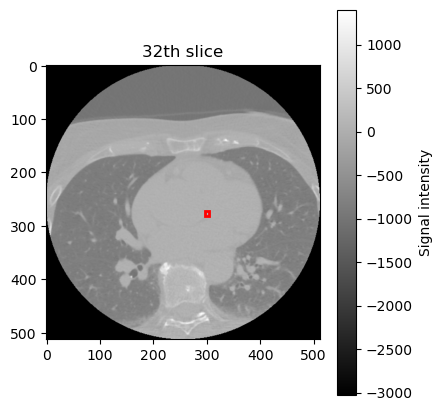

x_min, y_min:  (296.85765198737977, 272.3185920491322)


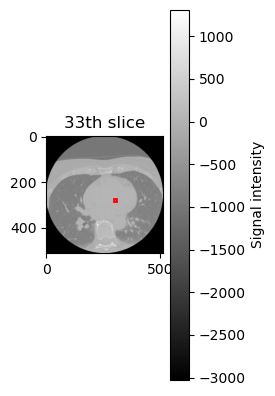

x_min, y_min:  (296.85765198737977, 272.3185920491322)


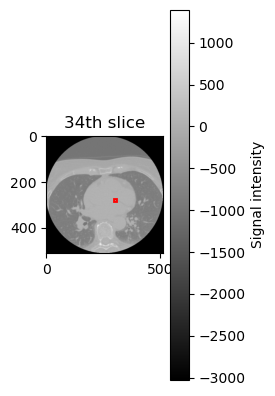

ValueError: num must be an integer with 1 <= num <= 3, not 4

<Figure size 640x480 with 0 Axes>

In [59]:
def plot_bbox(ct_scan, center_coordinates, dimension):
    """ Plot bounding given 3D image and 3D coordinates
    @param center_coordinates = [x,y,z]
    @param dimension = [length, width, height]"""
    length, width, height = dimension
    [x,y,z] = center_coordinates
    #x_min, y_min = center_coordinates[0] - width/2, center_coordinates[1] - height/2
    slice_idxs = [int(idx) for idx in range(int(z - length), int(z + length) + 1)]
    row, col = 1, 3
    if len(slice_idxs) >= col:
        #fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        plt.figure(figsize=(15,5))
        for i,idx in enumerate(slice_idxs):
            plt.subplot(row, col, i+1)
            plt.imshow(ct_scan[idx,:,:], cmap='gray')

            plot_single_slice_box(ct_scan[idx,:,:], [x,y], [width,height], title=f'{idx}th slice')

        #for i in range(3):
            #slice_image = ct_scan[slice_idxs[i], :, :]
            #ax[i].imshow(slice_image, cmap='gray')
            #ax[i].set_title(f"Slice {slice_idxs[i]}")
            #rect = plt.Rectangle((x_min, y_min), width, height, fill=False, edgecolor='red', linewidth=2)
            #ax[i].add_patch(rect)
        plt.show()

plot_bbox(ct_scan, center_coordinates, dimension)

x_min, y_min:  296.85765198737977 272.3185920491322
w, h:  7.346364512383218 9.047961255810506


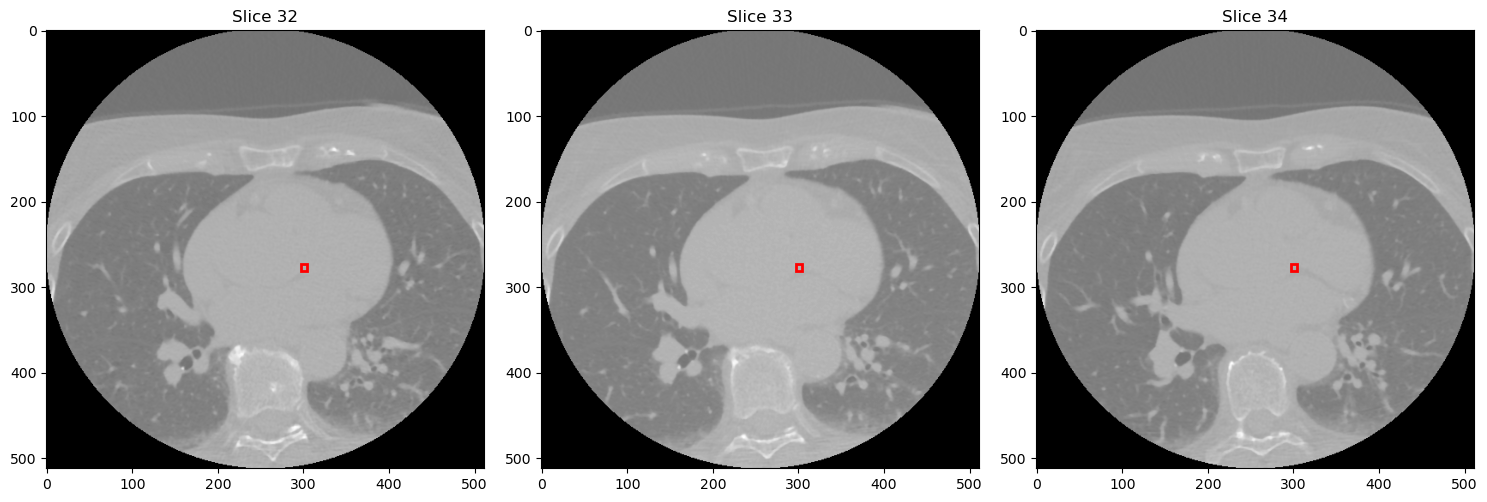

In [52]:
label_path = r'C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\bifurcation_point\3\bifurcation.json'
center_coordinates, dimension = get_3Dbox_coordinates(label_path, spacing)
plot_bbox(ct_scan, center_coordinates, dimension)

x_min, y_min:  (296.85765198737977, 272.3185920491322)


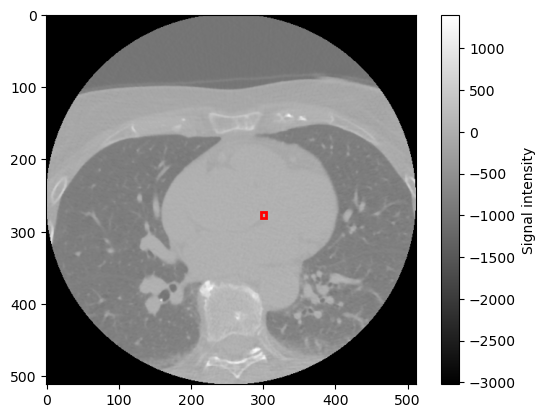

x,y :  [300.5308342435714, 276.8425726770374]
w,h :  [7.346364512383218, 9.047961255810506]


In [57]:
def plot_single_slice_box(slice, center, size, title=""):
  """
  Plots n-th slice of a scan
  Center is a list containing center_x, center_y
  Size is a list containing width, height
  """
  plt.imshow(slice, cmap=plt.cm.gray)
  if title != "":
    plt.title(title)
  w, h = size
  box = plt.Rectangle((center[0]-w/2, center[1]-h/2), w, h, fill=False, edgecolor='red', linewidth=2)
  print("x_min, y_min: ", (center[0]-w/2, center[1]-h/2)) 
  plt.gca().add_patch(box)
  plt.colorbar(label='Signal intensity')
  plt.show()

plot_single_slice_box(ct_scan[32,:,:], center=center_coordinates, size=dimension[1:])
print("x,y : ", center_coordinates[0:2])
print("w,h : ", dimension[1:])

In [38]:
def generate_yolo_labels(ct_scan, center_coordinates, dimension):
    # calculate bounding box coordinates respective to the image
    x_norm = center_coordinates[0] / ct_scan.shape[1]
    y_norm = center_coordinates[1] / ct_scan.shape[2]
    # get z slice indexes that contain bounding boxes
    # slice_idxs = [int(idx) for idx in range(int(z - l), int(z + l) + 1)]
    # if slice is in the slice_idxs list, then write the labels to text and save in path otherwise write empty txt file (no bifurcation)
    return x_norm, y_norm, dimension[1], dimension[2]

In [31]:
def clip_values(ct_scan, min_bound=-1000, max_bound=1000):
    """
    Clips outliers, if not specified min_bound=-1000 max_bound=1000
    """
    img = ct_scan
    img = np.clip(img, min_bound, max_bound).astype(np.float32)
    return img

In [32]:
def resample(ct_scan, spacing, out_spacing=[1.0,1.0,1.0], label_path=None):
    """ Resample images to 1mm spacing, if otherwise specify out_spacing value """
    resize_factor = spacing / out_spacing
    new_shape = ct_scan.shape * resize_factor
    real_resize_factor = new_shape / ct_scan.shape
    new_spacing = spacing / real_resize_factor
    resampled_scan = scipy.ndimage.zoom(ct_scan, real_resize_factor, mode='nearest')
    if label_path is not None:
        resampled_coordinates, resampled_dim = get_3Dbox_coordinates(label_path, new_spacing, scaling_factor=real_resize_factor)
        return resampled_scan, resampled_coordinates, resampled_dim
    return resampled_scan

resampled_scan, resampled_coordinates, resampled_dim = resample(ct_scan, spacing, label_path=label_path)
#plot_bbox(resampled_scan, resampled_coordinates, resampled_dim)
print("Resampled bounding box coordinates: ", resampled_coordinates)
print("Resampled bounding box dimensions: ", resampled_dim)
print("Resampled scan shape: ", resampled_scan.shape)
#plot_single_slice(resampled_scan)


Resampled bounding box coordinates:  [146.74349975585938, 135.17697143554688, 99.39756774902344]
Resampled bounding box dimensions:  [18.64875334  3.5870903   4.41794767]
Resampled scan shape:  (140, 250, 250)


In [128]:
#Probably a bad idea to use rotate augmentation for detection boxes
#def random_rotate3D(ct_scan, min_angle, max_angle, label_path=None):
#    """
#   Returns a random rotated array in the same shape
#   should be min_angle > -360 and max_angle < 360
#   """
#    all_axes = [(1, 0), (1, 2), (0, 2)]
#    angle = np.random.randint(low=min_angle, high=max_angle+1)
#    axes_random_id = np.random.randint(low=0, high=len(all_axes))
#    axes = all_axes[axes_random_id]
#    if label_path is not None:
#        return
#    return scipy.ndimage.rotate(ct_scan, angle, axes=axes)

#rotated_scan = random_rotate3D(ct_scan, min_angle=-180, max_angle=180)
#coordinates, dim = get_3Dbox_coordinates(label_path, spacing)
#plot_bbox_patches(rotated_scan, coordinates, dim)
#print(rotated_scan.shape)
#plot_single_slice(rotated_scan)

In [33]:
def random_flip(ct_scan, label_path=None, spacing=None):
    """Returns a random flipped 3d array"""
    axes = [0, 1, 2]
    rand = np.random.randint(0, 3)
    print(rand)
    img = np.flip(ct_scan, axis=axes[rand])
    img = np.squeeze(img)
    
    if label_path is not None:
        center, [l,w,h] = get_3Dbox_coordinates(label_path, spacing)
        return img, np.flip(np.array(center).reshape(3,1,-1), axis=axes[rand])
    return img

flipped_scan, flipped_center = random_flip(ct_scan, label_path=label_path, spacing=spacing)
#plot_bbox(ct_scan, center_coordinates, dimension)
print(flipped_center)
#plot_bbox(flipped_scan, flipped_center.reshape(3,), dimension)

2
[[[300.53083424]]

 [[276.84257268]]

 [[ 39.7590271 ]]]


In [139]:
def preprocess_scan(ct_scan_path, bbox=False, mask=False, label_path=None, resample=True, 
                    normalize=False, clip_values=False, random_flip=False, random_rotate3D=False):
    """Preprocess the given ct scan and label path"""
    
    
    

In [34]:
aorta_ct_path = r"C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\aorta\PD002\og_ct.nii"
aorta_ct_scan, aorta_origin, aorta_spacing = read_image(aorta_ct_path)
print("CT scan for aorta shape: ",aorta_ct_scan.shape)
print("CT scan for aorta origin: ", aorta_origin)
print("CT scan for  aorta spacing: ", aorta_spacing)

#plot_single_slice(aorta_ct_scan)

CT scan for aorta shape:  (47, 512, 512)
CT scan for aorta origin:  [1761.75         93.57398224  -46.68701935]
CT scan for  aorta spacing:  [3.         0.37599999 0.37599999]


In [35]:
aorta_mask_path = r"C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\aorta\PD002\aorta_mask.nii"
aorta_mask, mask_origin, mask_spacing = read_image(aorta_mask_path)
print("CT scan for aorta shape: ",aorta_mask.shape)
print("CT scan for aorta origin: ", mask_origin)
print("CT scan for  aorta spacing: ", mask_spacing)

#plot_single_slice(aorta_mask)

CT scan for aorta shape:  (47, 512, 512)
CT scan for aorta origin:  [1761.75         93.57398224  -46.68701935]
CT scan for  aorta spacing:  [3.         0.37599999 0.37599999]


In [ ]:
def mask_to_bbox_yolo(mask_path, plot=False):
    """Function to convert segmentation mask to bounding box
    returns center_x, center_y, w, h
    """
    mask = read_image(mask_path, only_img=True)
    for i in range(mask.shape[0]):





In [ ]:
def calculate_bbox_slice(mask_slice):
    """Accepts single 2D slice of a mask 
    returns center_x, center_y, w, h """
    non_zero_pixels = np.argwhere(mask_slice == 1)
    if len(non_zero_pixels) == 0:
        return None 
    min_row, min_col = np.min(non_zero_pixels, axis=0)
    max_row, max_col = np.max(non_zero_pixels, axis=0)
    center_x = (min_col + max_col) / 2
    center_y = (min_row + max_row) / 2
    width = max_col - min_col
    height = max_row - min_row
    return center_x, center_y, width, height

In [36]:
def get_index_segment_slice(mask):
    """Get index of the slices that contain segmentation"""
    segment_idx = []
    for i in range(mask.shape[0]):
        if sum(mask[i].ravel() > 0): #if there is a segmentation mask in slice i
            segment_idx.append(i)
    if not segment_idx:
        raise ValueError("There is no segmentation mask")
    else:
        return segment_idx

In [16]:
img = sitk.ReadImage(aorta_ct_path)
# Get the current origin
current_origin = img.GetOrigin()
# Calculate the translation vector to adjust the origin
translation = [0 - current_origin[0], 0 - current_origin[1], 0 - current_origin[2]]
# Apply the translation to the image
transform = sitk.TranslationTransform(3, translation)
transformed_img = sitk.Resample(img, transform)
transformed_img_np = sitk.GetArrayFromImage(transformed_img)
np.array(list(reversed(transformed_img.GetOrigin())))

array([1761.75      ,   93.57398224,  -46.68701935])

In [121]:
np.set_printoptions(precision=2, suppress=True)
img = nib.load(aorta_ct_path)
print(img.affine)
# Calculate the translation vector to adjust the origin
current_origin = img.affine[:3, 3]
print(current_origin)
vox_center = (np.array(img.shape) - 1) / 2.
print("vox center: ", vox_center)
print(nib.affines.apply_affine(img.affine, vox_center))


translation = np.array([0, 0, 0]) - current_origin

# Update the affine transformation matrix
new_affine = img.affine.copy()
new_affine[:3, 3] = current_origin + translation  # Correct the translation calculation


# Apply the translation to the image data
new_img = nib.Nifti1Image(img.get_fdata(), new_affine)

# Save the transformed image
#new_img = nib.Nifti1Image(new_data, new_affine)

print(new_img.affine)
#p = np.array(list(reversed(new_img.get_fdata())))
#plot_single_slice(img.get_fdata())
print(new_img.header.get_zooms())
print(new_img.header.get_qform())
nib.aff2axcodes(new_img.affine)


[[  -0.38   -0.      0.     46.69]
 [  -0.      0.38   -0.    -93.57]
 [   0.      0.      3.   1761.75]
 [   0.      0.      0.      1.  ]]
[  46.69  -93.57 1761.75]
vox center:  [255.5 255.5  23. ]
[ -49.38    2.49 1830.75]
[[-0.38 -0.    0.    0.  ]
 [-0.    0.38 -0.    0.  ]
 [ 0.    0.    3.    0.  ]
 [ 0.    0.    0.    1.  ]]
(0.376, 0.376, 3.0)
[[-0.38  0.    0.    0.  ]
 [ 0.    0.38  0.    0.  ]
 [ 0.    0.    3.    0.  ]
 [ 0.    0.    0.    1.  ]]


('L', 'A', 'S')

In [119]:
affine = np.eye(4)  # identity affine
voxel_data = np.random.normal(size=(4, 2, 3))
abc = nib.Nifti1Image(voxel_data, affine)

print(voxel_data)
voxel_data[0,0,:]


[[[-0.43 -1.12  0.37]
  [-1.01 -0.67  0.97]]

 [[ 0.7   0.57 -0.66]
  [-1.25 -0.2  -2.34]]

 [[ 2.15  1.8  -1.32]
  [ 0.47 -0.46 -0.16]]

 [[-2.01 -0.69 -1.9 ]
  [ 0.54  0.2   0.78]]]


array([-0.43, -1.12,  0.37])

In [ ]:
def plot_masks(ct_scan, mask):
    """Function to plot overlaying masks on top of the slices of the given CT scan image"""
    

In [125]:

# Create a sample 3D array
array_3d = np.array([[[1, 2, 3],
                      [4, 5, 6]],
                     
                     [[7, 8, 9],
                      [10, 11, 12]]])

# Flip the 3D array along different axes
flipped_along_x = np.flip(array_3d, axis=0)
flipped_along_y = np.flip(array_3d, axis=1)
flipped_along_z = np.flip(array_3d, axis=2)

print("Original Array:")
print(array_3d)

print("\nFlipped along X-axis:")
print(flipped_along_x)

print("\nFlipped along Y-axis:")
print(flipped_along_y)

print("\nFlipped along Z-axis:")
print(flipped_along_z)


Original Array:
[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]

Flipped along X-axis:
[[[ 7  8  9]
  [10 11 12]]

 [[ 1  2  3]
  [ 4  5  6]]]

Flipped along Y-axis:
[[[ 4  5  6]
  [ 1  2  3]]

 [[10 11 12]
  [ 7  8  9]]]

Flipped along Z-axis:
[[[ 3  2  1]
  [ 6  5  4]]

 [[ 9  8  7]
  [12 11 10]]]


In [3]:
import os
folder_path = r'C:\Users\sanatbyeka\Desktop\calcium_scoring\data\raw\aorta'  # Replace with the actual folder path

for folder in os.listdir(folder_path):
    infolder = os.path.join(folder_path, folder)
    for filename in os.listdir(infolder):
        file_path = os.path.join(infolder, filename)
        if filename.endswith(".nrrd"):
            os.remove(file_path)
            print(f"Deleted {filename}")

Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd
Deleted Segmentation.seg.nrrd


In [144]:
import numpy as np

# Given information
original_orientation = np.array([[-1, -0, -0],
                                 [-0, -1, -0],
                                 [0, 0, 1]])

# Determine the flipping axis
flipping_axis = 0  # X-axis

# Flip the center coordinates
flipped_center = center_coordinates * np.array([-1, 1, 1])

# If needed, adjust dimensions based on the flipped orientation
adjusted_dimensions = dimension * np.abs(np.diagonal(original_orientation))

print("Original Center:", center)
print("Flipped Center:", flipped_center)
print("Adjusted Dimensions:", adjusted_dimensions)


Original Center: [146.74349975585938, 135.17697143554688, 99.39756774902344]
Flipped Center: [-300.53083424  276.84257268   39.7590271 ]
Adjusted Dimensions: [7.45950134 7.34636451 9.04796126]
